#Plane wave beamforming with optimizer

In [1]:
%matplotlib inline
import sys
import os.path
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from itertools import islice
sys.path.append("/Users/edwardlrichards/compAcoustics") 

from sklearn.linear_model import MultiTaskLasso, Lasso, Ridge

import beamformers as bf
np.random.seed(0)

In [2]:
# experiment specifications
f = 200
c = 1500
spacing = 0.5  # lambda
numEl = 20
numLook = 2e2
numSnaps = 40
# thetaSource = [-0.3758, 0.284723]  # offgrid look direction
thetaSource = [-0.3758, -0.30, 0.284723]  # offgrid look direction

In [3]:
omega = 2 * np.pi * f
waveLength = c / f
arrayPosition = np.arange(numEl) * np.pi
thetaLook = np.r_[0 : np.pi : numLook * 1j] - (np.pi / 2)
# Make grid of look vectors
W = np.exp(1j * np.sin(thetaLook)[:,None] * arrayPosition)
W = W / np.linalg.norm(W, axis=1)[:,None]

In [4]:
SNR = 30  # dB
K = []
for tS in thetaSource:
    dataVector = np.exp(1j * np.sin(tS) * arrayPosition)
    
    K.append(np.outer(dataVector, dataVector.conj()))

K = np.array(K)
K = np.sum(K, axis=0)

#Diagonal load for SNR
U, S, V = np.linalg.svd(K)
topEig = S[0] ** 2
snrLin = 10 ** (SNR / 10)
noiseVar = (topEig / snrLin) / (1 - (1 / snrLin))

K += noiseVar * np.eye(numEl)

#simulate data vector
noise = np.random.randn(numEl, numSnaps)

# Regualrize cholesky
L = np.linalg.cholesky(K)

simulatedData = np.dot(L, noise)

kSim = []
for sim in simulatedData.T:
    kSim.append(np.outer(sim, sim.conj()))

kSim = np.array(kSim)
kSim = np.mean(kSim, axis=0)

measuredDataVector = simulatedData[:,0]

In [5]:
B_bart = bf.bartlet(kSim, W)
B_bart = 10 * np.log10(np.abs(B_bart))
B_bart -= np.max(B_bart)

In [6]:
# minimization solvers
X = W.T
XSplit = np.vstack((np.hstack((X.real, X.imag)),\
                    np.hstack((-X.imag, X.real))))

constraint1 = []
constraint2 = []
for snap in simulatedData.T:
    constraint1.append(np.vstack((snap.real, snap.imag)))
    constraint2.append(np.vstack((-snap.imag, snap.real)))

constraint1 = np.array(constraint1)
constraint1 = constraint1.reshape(numSnaps * 2, numEl).T
constraint2 = np.array(constraint2)
constraint2 = constraint2.reshape(numSnaps * 2, numEl).T

Y_stack = np.vstack((constraint1, constraint2))

In [7]:
# Split W into real and imagninary
lasso_solver = MultiTaskLasso(alpha=0.5, max_iter=1e4)
task_lasso = lasso_solver.fit(XSplit, Y_stack)
result = task_lasso.coef_[0,:]
result = result[:numLook] + 1j * result[numLook:]
B_sparse = 20 * np.log10(np.abs(result) + np.spacing(1))
B_sparse -= np.max(B_sparse)

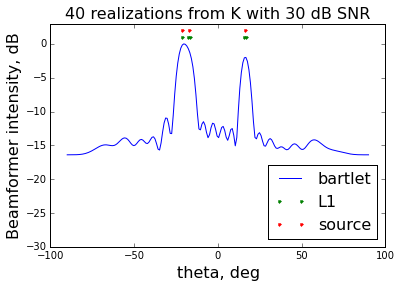

In [8]:
_ = plt.plot(np.rad2deg(thetaLook), B_bart, label='bartlet')
t_nonZero = thetaLook[B_sparse > -50]
_ = plt.plot(np.rad2deg(t_nonZero), np.ones(t_nonZero.shape), 'g.', label='L1')
# _ = plt.plot(np.rad2deg(thetaLook), B_sparse, label='lasso')

for i, tS in enumerate(thetaSource):
    if i == 0:
        _ = plt.plot(np.rad2deg(tS), 2, 'r.', label='source')
    else:
        _ = plt.plot(np.rad2deg(tS), 2, 'r.')

_ = plt.ylim(-30, 3)
_ = plt.legend(loc=4, fontsize=16)
_ = plt.title('%i realizations from K with %i dB SNR' %(numSnaps, SNR), fontsize=16)
_ = plt.xlabel('theta, deg', fontsize=16)
_ = plt.ylabel('Beamformer intensity, dB', fontsize=16)


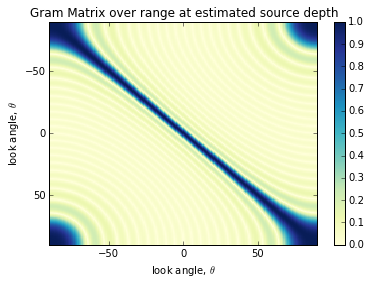

In [9]:
# Gram matrix
gram = np.abs(np.dot(W.conj(), W.T))
tRange = np.outer(np.rad2deg(thetaLook), np.ones(thetaLook.shape))
_ = plt.pcolormesh(tRange, tRange.T, gram, cmap=plt.cm.YlGnBu)
_ = plt.ylim(90, -90)
_ = plt.xlim(-90, 90)
cbar = plt.colorbar()
_ = plt.title('Gram Matrix over range at estimated source depth')
_ = plt.xlabel(r'look angle, $\theta$')
_ = plt.ylabel(r'look angle, $\theta$')


In [10]:
SNR = 15  # dB
K = []
for tS in thetaSource:
    dataVector = np.exp(1j * np.sin(tS) * arrayPosition)
    
    K.append(np.outer(dataVector, dataVector.conj()))

K = np.array(K)
K = np.sum(K, axis=0)

#Diagonal load for SNR
U, S, V = np.linalg.svd(K)
topEig = S[0] ** 2
snrLin = 10 ** (SNR / 10)
noiseVar = (topEig / snrLin) / (1 - (1 / snrLin))

K += noiseVar * np.eye(numEl)

#simulate data vector
noise = np.random.randn(numEl, numSnaps)

# Regualrize cholesky
L = np.linalg.cholesky(K)

simulatedData = np.dot(L, noise)

kSim = []
for sim in simulatedData.T:
    kSim.append(np.outer(sim, sim.conj()))

kSim = np.array(kSim)
kSim = np.mean(kSim, axis=0)

In [11]:
B_bart = bf.bartlet(kSim, W)
B_bart = 10 * np.log10(np.abs(B_bart))
B_bart -= np.max(B_bart)

In [12]:
# minimization solvers
X = W.T
XSplit = np.vstack((np.hstack((X.real, X.imag)),\
                    np.hstack((-X.imag, X.real))))

constraint1 = []
constraint2 = []
for snap in simulatedData.T:
    constraint1.append(np.vstack((snap.real, snap.imag)))
    constraint2.append(np.vstack((-snap.imag, snap.real)))

constraint1 = np.array(constraint1)
constraint1 = constraint1.reshape(numSnaps * 2, numEl).T
constraint2 = np.array(constraint2)
constraint2 = constraint2.reshape(numSnaps * 2, numEl).T

Y_stack = np.vstack((constraint1, constraint2))

In [13]:
# Split W into real and imagninary
lasso_solver = MultiTaskLasso(alpha=0.9, max_iter=1e4)
task_lasso = lasso_solver.fit(XSplit, Y_stack)
result = task_lasso.coef_[0,:]
result = result[:numLook] + 1j * result[numLook:]
B_sparse = 20 * np.log10(np.abs(result) + np.spacing(1))
B_sparse -= np.max(B_sparse)

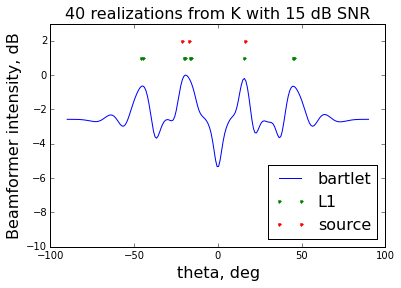

In [14]:
_ = plt.plot(np.rad2deg(thetaLook), B_bart, label='bartlet')
t_nonZero = thetaLook[B_sparse > -100]
_ = plt.plot(np.rad2deg(t_nonZero), np.ones(t_nonZero.shape), 'g.', label='L1')

for i, tS in enumerate(thetaSource):
    if i == 0:
        _ = plt.plot(np.rad2deg(tS), 2, 'r.', label='source')
    else:
        _ = plt.plot(np.rad2deg(tS), 2, 'r.')

_ = plt.ylim(-10, 3)
_ = plt.legend(loc=4, fontsize=16)
_ = plt.title('%i realizations from K with %i dB SNR' %(numSnaps, SNR), fontsize=16)
_ = plt.xlabel('theta, deg', fontsize=16)
_ = plt.ylabel('Beamformer intensity, dB', fontsize=16)
